In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns 
import xgboost as xgb
from sklearn.model_selection import train_test_split
import spacy
from sklearn.neighbors import KNeighborsClassifier
from spacy import displacy
from gensim.similarities.annoy import AnnoyIndexer
from sklearn.tree import DecisionTreeClassifier
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
import nltk
from sklearn.datasets import fetch_20newsgroups
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.gridspec as gridspec
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
df = pd.read_csv('../input/iba-ml1-final-project/train.csv')
df.head()

,Id,Age,Review_Title,Review,Pos_Feedback_Cnt,Division,Department,Product_Category,Rating,Recommended
0,17274,34,Cute fall/holiday top,Love this top! the quality is magnificent and ...,1,General,Tops,Blouses,5,1
1,5921,35,NaN,NaN,0,General,Tops,Blouses,5,1
2,16479,40,Disappointed,"Sleeves were tight, was difficult to put on ?....",15,General,Tops,Blouses,2,0
3,1925,28,Gorgeous detailing,I never write reviews but this clothe is so fa...,3,General Petite,Clothes,Clothes,5,1
4,5691,39,Cute and comfortable tee!,Love this tshirt! casual but can be clotheed u...,0,General,Tops,Knits,5,1


## Deal with missing value imputations (more detailed version is in EDA notebook)

In [3]:
df['Product_Category'] = df['Product_Category'].fillna(value=df['Product_Category'].mode()[0])
df['Department'] = df['Department'].fillna(value=df['Department'].mode()[0])
df['Division'] = df['Division'].fillna(value=df['Division'].mode()[0])
df['Review'] = df['Review'].fillna(value='nan')
df['Review_Title'] = df['Review_Title'].fillna(value='nan')

In [4]:
df['Rating'] = df['Rating'].apply(lambda s: str(s))
df['Recommended'] = df['Recommended'].apply(lambda s: str(s))

In [5]:
msk = np.random.rand(len(df)) < 0.8
train_df = df[msk]
test_df = df[~msk]

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report

In [7]:
clf = Pipeline(steps=[
    ('vectorization', CountVectorizer()),
#     ('feature_selection', SelectKBest(f_classif, 10000)),
    ('classification', DecisionTreeClassifier(max_depth=10))
])
clf.fit(train_df['Review'], train_df['Recommended'])
print('ROC score',roc_auc_score(test_df['Recommended'], clf.predict(test_df['Review'])))
print("F1 score", f1_score(test_df['Recommended'], clf.predict(test_df['Review']), average="binary", pos_label='1'))

ROC score 0.6245442126562517
F1 score 0.9095315024232633


In [8]:
clf = Pipeline(steps=[
    ('vectorization', CountVectorizer()),
#     ('feature_selection', SelectKBest(f_classif, 10000)),
    ('classification', xgb.XGBClassifier())
])
clf.fit(train_df['Review'], train_df['Recommended'])
print('ROC score',roc_auc_score(test_df['Recommended'], clf.predict(test_df['Review'])))
print("F1 score", f1_score(test_df['Recommended'], clf.predict(test_df['Review']), average="binary", pos_label='1'))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC score 0.716430941155928
F1 score 0.9313164349959117


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(train_df['Review']).toarray()
labels = train_df.Rating

In [35]:
features.shape

(11247, 10507)

In [36]:
labels.shape

(11247,)

In [15]:
models = [
#     RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
#     CatBoostClassifier(silent=True),
    
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


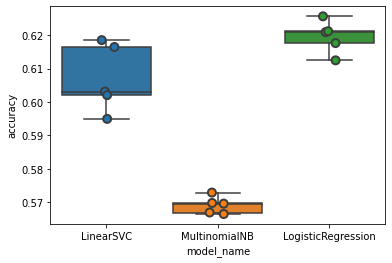

In [16]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [17]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.607006
LogisticRegression    0.619544
MultinomialNB         0.569129
Name: accuracy, dtype: float64

In [22]:
rating_df = df[['Rating']].drop_duplicates().sort_values('Rating')

In [39]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=df['Rating'].unique()))

              precision    recall  f1-score   support

           5       0.37      0.11      0.17       138
           2       0.29      0.19      0.23       237
           3       0.35      0.29      0.32       440
           1       0.37      0.28      0.32       784
           4       0.73      0.88      0.80      2113

    accuracy                           0.61      3712
   macro avg       0.42      0.35      0.37      3712
weighted avg       0.57      0.61      0.58      3712



In [40]:
model = LGBMClassifier()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=df['Rating'].unique()))

              precision    recall  f1-score   support

           5       0.40      0.12      0.19       138
           2       0.27      0.15      0.19       237
           3       0.36      0.30      0.32       440
           1       0.40      0.27      0.32       784
           4       0.72      0.91      0.81      2113

    accuracy                           0.62      3712
   macro avg       0.43      0.35      0.37      3712
weighted avg       0.57      0.62      0.59      3712



In [125]:
clf = LogisticRegression()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_df.index, test_size=0.33, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=df['Rating'].unique()))

ValueError: Found input variables with inconsistent numbers of samples: [11247, 11247, 11279]

In [43]:
model = xgb.XGBClassifier()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=df['Rating'].unique()))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:14:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           5       0.42      0.14      0.22       138
           2       0.28      0.11      0.16       237
           3       0.38      0.27      0.31       440
           1       0.40      0.25      0.31       784
           4       0.71      0.93      0.80      2113

    accuracy                           0.62      3712
   macro avg       0.44      0.34      0.36      3712
weighted avg       0.57      0.62      0.58      3712



In [44]:
print('he')

he


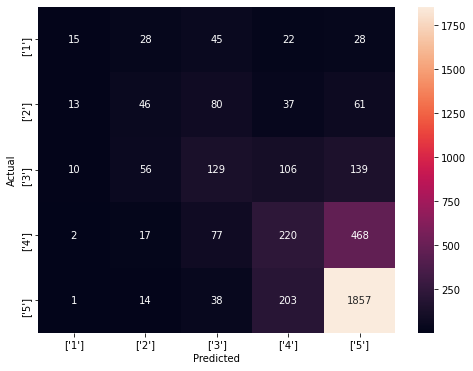

In [23]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=rating_df.values, yticklabels=rating_df.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [126]:
df = pd.read_csv('../input/iba-ml1-final-project/train.csv')
df.head()

,Id,Age,Review_Title,Review,Pos_Feedback_Cnt,Division,Department,Product_Category,Rating,Recommended
0,17274,34,Cute fall/holiday top,Love this top! the quality is magnificent and ...,1,General,Tops,Blouses,5,1
1,5921,35,NaN,NaN,0,General,Tops,Blouses,5,1
2,16479,40,Disappointed,"Sleeves were tight, was difficult to put on ?....",15,General,Tops,Blouses,2,0
3,1925,28,Gorgeous detailing,I never write reviews but this clothe is so fa...,3,General Petite,Clothes,Clothes,5,1
4,5691,39,Cute and comfortable tee!,Love this tshirt! casual but can be clotheed u...,0,General,Tops,Knits,5,1


In [127]:
df['Product_Category'] = df['Product_Category'].fillna(value=df['Product_Category'].mode()[0])
df['Department'] = df['Department'].fillna(value=df['Department'].mode()[0])
df['Division'] = df['Division'].fillna(value=df['Division'].mode()[0])
df['Review'] = df['Review'].fillna(value='nan')
df['Review_Title'] = df['Review_Title'].fillna(value='nan')

In [128]:
df['Rating'] = df['Rating'].apply(lambda s: str(s))
# df['Recommended'] = df['Recommended'].apply(lambda s: str(s))

In [48]:
msk = np.random.rand(len(df)) < 0.8
train_df = df[msk]
test_df = df[~msk]

In [144]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter

In [151]:
X = df['Review'].values
y1 = df['Rating']
y2 = df['Recommended']
X_train, X_test, y_train, y_test = train_test_split(X, y2)

In [152]:
VOCAB_SIZE = 20000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

In [155]:
model = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # VOCAB_SIZE + 1 (1 for padding token)
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [156]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/10
331/331 [==============================] - 15s 26ms/step - loss: 0.4830 - accuracy: 0.8222 - val_loss: 0.2838 - val_accuracy: 0.8802
Epoch 2/10
331/331 [==============================] - 7s 20ms/step - loss: 0.2222 - accuracy: 0.9085 - val_loss: 0.2813 - val_accuracy: 0.8814
Epoch 3/10
331/331 [==============================] - 7s 22ms/step - loss: 0.1660 - accuracy: 0.9401 - val_loss: 0.2844 - val_accuracy: 0.8850
Epoch 4/10
331/331 [==============================] - 7s 22ms/step - loss: 0.1229 - accuracy: 0.9571 - val_loss: 0.3096 - val_accuracy: 0.8845
Epoch 00004: early stopping


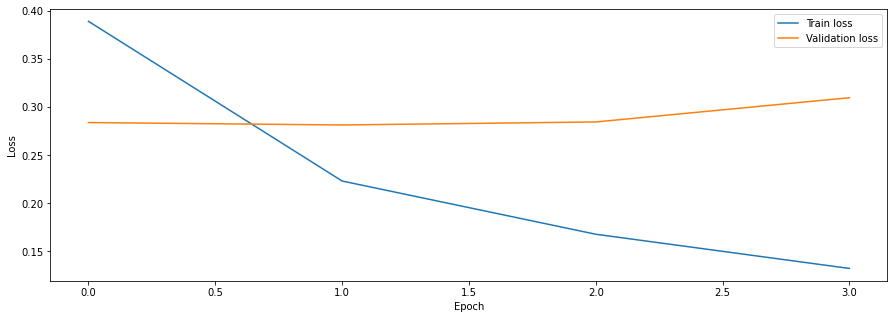

In [157]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

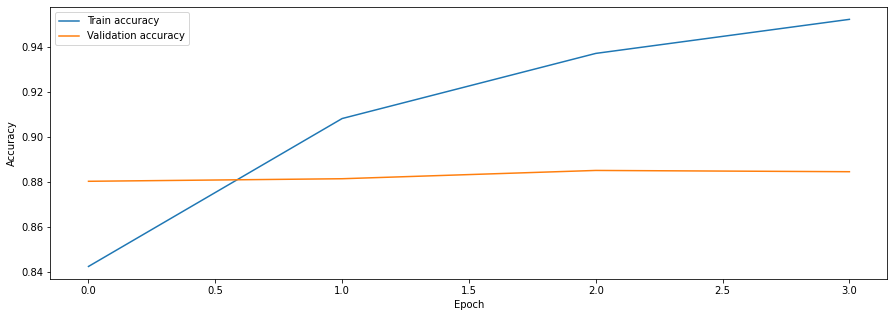

In [158]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [159]:
labenc = LabelEncoder()
labenc.fit(y1)
encoded_Y = labenc.transform(y1)
dummy_y = np_utils.to_categorical(encoded_Y)

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y)

In [161]:
model1 = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # VOCAB_SIZE + 1 (1 for padding token)
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [162]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model1.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/30
331/331 [==============================] - 14s 26ms/step - loss: 1.2570 - accuracy: 0.5537 - val_loss: 0.9364 - val_accuracy: 0.6097
Epoch 2/30
331/331 [==============================] - 7s 22ms/step - loss: 0.8758 - accuracy: 0.6408 - val_loss: 0.9045 - val_accuracy: 0.6336
Epoch 3/30
331/331 [==============================] - 7s 21ms/step - loss: 0.8013 - accuracy: 0.6735 - val_loss: 0.9355 - val_accuracy: 0.6301
Epoch 4/30
331/331 [==============================] - 7s 20ms/step - loss: 0.7462 - accuracy: 0.6928 - val_loss: 0.9278 - val_accuracy: 0.6242
Epoch 00004: early stopping


In [89]:
test_df = pd.read_csv('../input/iba-ml1-final-project/test.csv')
test_df.head()

,Id,Age,Review_Title,Review,Pos_Feedback_Cnt,Division,Department,Product_Category
0,21403,53,Magnificent clothe!,"In contrast to the other reviewer, i love this...",4,General,Clothes,Clothes
1,22553,51,Shapeless tent,I tried this on in the store and it was huge. ...,2,General,Clothes,Clothes
2,17436,59,Versatile and then some,"I thought this was a fun piece to have, but di...",1,General,Bottoms,Trousers
3,4293,48,So simple but so cute!,I bought the multi-color stripe and it is ador...,1,General,Clothes,Clothes
4,20149,46,Magnificent simple tank,The wide strap style is very flattering. this ...,0,Initmates,Intimate,Layering


In [90]:
test_df.isna().sum()

Id                     0
Age                    0
Review_Title        1451
Review               342
Pos_Feedback_Cnt       0
Division               3
Department             3
Product_Category       3
dtype: int64

In [91]:
test_df['Product_Category'] = test_df['Product_Category'].fillna(value=test_df['Product_Category'].mode()[0])
test_df['Department'] = test_df['Department'].fillna(value=test_df['Department'].mode()[0])
test_df['Division'] = test_df['Division'].fillna(value=test_df['Division'].mode()[0])
test_df['Review'] = test_df['Review'].fillna(value='nan')
test_df['Review_Title'] = test_df['Review_Title'].fillna(value='nan')

In [92]:
test_df.isna().sum()

Id                  0
Age                 0
Review_Title        0
Review              0
Pos_Feedback_Cnt    0
Division            0
Department          0
Product_Category    0
dtype: int64

In [163]:
recommended_predicted = model.predict_classes(test_df['Review'])
np.unique(recommended_predicted, return_counts=True)

rating_predicted = model1.predict_classes(test_df['Review'])
np.unique(rating_predicted, return_counts=True)

submission = pd.read_csv('../input/iba-ml1-final-project/sample_submission.csv')

submission['Rating'] = rating_predicted
submission['Recommended'] = recommended_predicted

submission.to_csv('submission2.csv', index=False)

In [164]:
stats.spearmanr(rating_predicted, recommended_predicted)

SpearmanrResult(correlation=0.6265142223646445, pvalue=0.0)

In [147]:
stats.spearmanr(rating_predicted, recommended_predicted)

SpearmanrResult(correlation=0.6145276185464358, pvalue=0.0)